<a href="https://colab.research.google.com/github/jpsiegel/Projects/blob/master/Feudal_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Trello:

### Done
* Minimo viable visual **CHK**
  * particionar matriz gobernador **CHK**
  * particionar matriz señor **CHK**
  * particionar matriz vasallo **CHK**
  * Conectar el update **CHK**
* Actualizar valores por etapa (loyalties y army) **CHK**
  * Actualizar loyalties segun decay rate **CHK**
  * Actualizar armies segun grow rate **CHK**
* arreglar BUG: finds deben funcionar con config no con all_list **CHK**
* Generar reglas
  * segun army_value semi **CHK**
    * vasallo ataca segun fuerza de neighbours: attack lowest army value neighbour if im the strongest of the neighbour (neighbour is all but self) **CHK**
    * si vecino de vasallo controla mas de un feudo a su alrededor, army value se suma (favorece ataque a regiones aisladas o feudos chicos) **CHK**
* Generar consecuencias de conquista
  * Vasallos **chk**
  * Lords
  * Govs

### To Do (entrega3)
* Checkear bugs:
  * que no crucen mapa
  * que no haya conflicto en hitmap
  * que encuentre target correcto
  * que pasa cuando vasallo ataca: le pasa su id a ese cuadro (que pasa con army value? adopta porcion? pierde otro par)
  * que pasa cuando gov/lord ataca: toma toda la region de ese gov/lord
* Hacer ataques y conquistas de lords/govs!!
* Generar reglas
  * segun loyalties
  * mixtas?
* Analisis:
  * Grafico de area por Gov (histograma simple)
* Hacer funcion generadora de condiciones iniciales



In [1]:
import matplotlib
from pylab import *
from IPython import display
import time
import numpy as np
from random import uniform, seed

In [2]:
# Parameters

vassal_grid_size = 5 # n x n
lord_grid_size = vassal_grid_size - 2
governor_grid_size = lord_grid_size - 1

initial_army_level_min, initial_army_level_max = 0.1, 2  # starts low, [1, 10]
initial_loyalty_value = 1.0 # starts at max, [0.0, 1.0]
army_growth_rate = 0.1
loyalty_decay_rate = 0.01
army_portion_left_on_new_conquest = 1/2

In [3]:
# Classes


class Vassal:  # Vasallo

  def __init__(self, id_, initial_army_level, initial_loyalties_up, coord_x, coord_y):
    self.id_ = id_ #este es su nombre, si conquista mas feudos este se traspasa
    self.coords = (coord_x, coord_y) #coordenadas, inmutables
    self.army_value = initial_army_level
    self.loyalties_up = initial_loyalties_up #dict: {L1: loyalty_value1, L2: l_v2}

  def __repr__(self):
    return "Vassal{} a_v:{} l_up:{}".format(self.id_, self.army_value, self.loyalties_up)


class Lord:  # Señor

  def __init__(self, id_, initial_loyalties_up, initial_loyalties_down):
    self.id_ = id_
    self.loyalties_up = initial_loyalties_up  # dict: {G1: loyalty_value1, G2: l_v2}
    self.loyalties_down = initial_loyalties_down  # dict: {V1: loyalty_value1, V2: l_v2}
    
  def army_value(self):
    """Function to calculate army value of Lord given its loyalties down"""
    pass

  def __repr__(self):
    return "Lord{} l_down:{}".format(self.id_, self.loyalties_down)


class Governor:  # Gobernador

  def __init__(self, id_, initial_loyalties_down):
    self.id_ = id_
    self.loyalties_down = initial_loyalties_down  # dict: {L1: loyalty_value1, L2: l_v2}
    
  def army_value(self):
    """Function to calculate army value of Governor given its loyalties down"""
    pass

  def __repr__(self):
    return "Governor{} l_down:{}".format(self.id_, self.loyalties_down)

In [4]:
#Auxiliar functions

def connect_down(A, B, value=initial_loyalty_value):
  """Connects A down to B. A will have a loyalties_down pointing to B.
  B will have a loyalties_up pointing to A"""
  A.loyalties_down[B.id_] = value
  B.loyalties_up[A.id_] = value

def connect_all():
  """ Given a grid size, this generates random valid starting conditions for the connections"""
  pass

def print_connections(vassal_config, lord_config, governor_config):
    print("Vassal Config:")
    print(vassal_config)
    print("")
    print("Lord Config:")
    print(lord_config)
    print("")
    print("Governor Config:")
    print(governor_config)
    print("")

def find_lord_of_vassal(vassal):
  """ Given a vassal object, returns the lord object connected with him """
  lord_id = list(vassal.loyalties_up.keys())[0]  # id of first lord connected
  target_lord = None
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      if lord_config[x,y].id_ == lord_id:
        target_lord = lord_config[x,y]
        return target_lord
  if target_lord == None:
    raise ValueError("Vassal's lord not found in lord_config")

def find_governor_of_vassal(vassal):
  """ Given a vassal object, returns the governor object connected with him through a lord"""
  lord = find_lord_of_vassal(vassal)
  governor_id = list(lord.loyalties_up.keys())[0]  # id of first governor connected
  target_governor = None
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      if governor_config[x, y].id_ == governor_id:
        target_governor = governor_config[x, y]
        return target_governor
  if target_governor == None:
    raise ValueError("Vassal's governor not found in governor_config")

def find_vassal_by_id(attacker_id): #cuidao que este es con nextconfig #CAMBIAR A FIND BY COORDS?
  for x in range(vassal_grid_size):
    for y in range(vassal_grid_size):
      if attacker_id == vassal_nextconfig[x,y].id_:
        return vassal_nextconfig[x,y]


In [5]:
# backend

def initialize(pattern=1, printy=False):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig, all_vassals, all_lords, all_governors
    seed(pattern)  # if uncommented, all executions give same pattern of army values #nice patterns -> 3 (1 consume todo), 9 (pugna entre 3), 10 (uno consume todo), 17 (bug de alternancia), 24, 26 BUG hitmap, 27

    #initialize vassal level
    vassal_config = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {}, -1, -1)))

    id_counter = 1
    for x in range(vassal_grid_size):
      for y in range(vassal_grid_size):
        initial_army_level = round(uniform(initial_army_level_min, initial_army_level_max), 3)
        new_vassal = Vassal(id_counter, initial_army_level, {}, x, y)
        vassal_config[x, y] = new_vassal
        id_counter += 1

    vassal_nextconfig = np.zeros([vassal_grid_size, vassal_grid_size], dtype=type(Vassal(None, 1, {}, -1, -1)))

    #initialize lord level
    lord_config = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    id_counter = 1
    for x in range(lord_grid_size):
      for y in range(lord_grid_size):
        new_lord = Lord(id_counter, {}, {})
        lord_config[x, y] = new_lord
        id_counter += 1

    lord_nextconfig = np.zeros([lord_grid_size, lord_grid_size], dtype=type(Lord(None, {}, {})))

    #initialize governor level
    governor_config = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    id_counter = 1
    for x in range(governor_grid_size):
      for y in range(governor_grid_size):
        new_governor = Governor(id_counter, {})
        governor_config[x, y] = new_governor
        id_counter += 1

    governor_nextconfig = np.zeros([governor_grid_size, governor_grid_size], dtype=type(Governor(None, {})))

    #connect all levels (random initial condition (WIP))
    #connect_all()
    
    #connect all levels (deterministic initial condition)
    #connect govs
    #1st gov
    connect_down(governor_config[0,0], lord_config[0, 0])
    connect_down(governor_config[0,0], lord_config[1, 0])
    #2nd gov
    connect_down(governor_config[0,1], lord_config[0, 1])
    connect_down(governor_config[0,1], lord_config[0, 2])
    #3rd gov
    connect_down(governor_config[1,0], lord_config[1, 1])
    connect_down(governor_config[1,0], lord_config[1, 2])
    connect_down(governor_config[1,0], lord_config[2, 2])
    #4th gov
    connect_down(governor_config[1,1], lord_config[2, 0])
    connect_down(governor_config[1,1], lord_config[2, 1])
    
    #connect lords
    #1st lord
    connect_down(lord_config[0,0], vassal_config[0, 0])
    connect_down(lord_config[0,0], vassal_config[1, 0])
    connect_down(lord_config[0,0], vassal_config[0, 1])
    #2do lord
    connect_down(lord_config[0,1], vassal_config[0, 2])
    connect_down(lord_config[0,1], vassal_config[1, 2])
    connect_down(lord_config[0,1], vassal_config[0, 3])
    #3rd lord
    connect_down(lord_config[0,2], vassal_config[1, 3])
    connect_down(lord_config[0,2], vassal_config[0, 4])
    connect_down(lord_config[0,2], vassal_config[1, 4])
    connect_down(lord_config[0,2], vassal_config[2, 4])
    #4th lord
    connect_down(lord_config[1,0], vassal_config[2, 0])
    connect_down(lord_config[1,0], vassal_config[1, 1])
    connect_down(lord_config[1,0], vassal_config[2, 1])
    #5th lord
    connect_down(lord_config[1,1], vassal_config[2, 2])
    connect_down(lord_config[1,1], vassal_config[3, 2])
    connect_down(lord_config[1,1], vassal_config[2, 3])
    #6th lord
    connect_down(lord_config[1,2], vassal_config[3, 3])
    connect_down(lord_config[1,2], vassal_config[3, 4])
    connect_down(lord_config[1,2], vassal_config[4, 4])
    #7th lord
    connect_down(lord_config[2,0], vassal_config[3, 0])
    connect_down(lord_config[2,0], vassal_config[4, 0])
    #8th lord
    connect_down(lord_config[2,1], vassal_config[3, 1])
    connect_down(lord_config[2,1], vassal_config[4, 1])
    #9th lord
    connect_down(lord_config[2,2], vassal_config[4, 2])
    connect_down(lord_config[2,2], vassal_config[4, 3])

    if printy:
      print_connections(vassal_config, lord_config, governor_config)


def observe(year, ca_level="lord", color_map="viridis"):
    global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig
    cla()
    if ca_level == "vassal":  # plot vassal level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          aux_config[x,y] = vassal_config[x,y].id_ #cambia instancia por id
      

    if ca_level == "lord":  # plot lord level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size): 
          # cambia instancia de vassal por id del primer lord conectado
          # normalizamos para usar toda la escala de colores
          lord_id = find_lord_of_vassal(vassal_config[x,y]).id_
          normalized_id = (vassal_grid_size / lord_grid_size) * (lord_id - 1)
          aux_config[x,y] = normalized_id  


    if ca_level == "governor":  # plot governor level
      aux_config = np.zeros([vassal_grid_size, vassal_grid_size])
      for x in range(vassal_grid_size):
        for y in range(vassal_grid_size):
          # cambia instancia de vassal por id del primer gov conectado
          # normalizamos para usar toda la escala de colores
          gov_id = find_governor_of_vassal(vassal_config[x,y]).id_
          normalized_id = (vassal_grid_size / governor_grid_size) * (gov_id - 1) 
          aux_config[x,y] = normalized_id  

    #print("Year:", year)
    imshow(aux_config, vmin = 0, vmax = vassal_grid_size * vassal_grid_size, cmap = color_map)

    #print_connections(vassal_config, lord_config, governor_config)

def update(printy=False):
  """ First we update army_value and loyalties for all vassals/lords/govs, then we generate decisions/actions for gov,lord,vassal """
  global vassal_config, vassal_nextconfig, lord_config, lord_nextconfig, governor_config, governor_nextconfig

  vassal_hitmap = {}  # {attacker_coords: target_coords}
  # iterate through vassal grid
  for x in range(vassal_grid_size):
    for y in range(vassal_grid_size):
      current_vassal = vassal_config[x, y]
      updated_army_value = round(current_vassal.army_value * (1 + army_growth_rate), 3)  # in each step army value grows by army_growth_rate
      updated_loyalties = {k: v * (1 - loyalty_decay_rate) for k, v in current_vassal.loyalties_up.items()}  # in each step loyalty decays by loyalty_decay_rate
      vassal_nextconfig[x, y] = Vassal(current_vassal.id_, updated_army_value, updated_loyalties, x, y)

      # iterate thorugh neighbourhood
      neighbours_army_values = {}  # coords: value
      aux_army_values = {} # id: value, es para sumar los del mismo id
      for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
          try:
            current_neighbour = vassal_config[x + dx, y + dy]
          except IndexError: #skip if coords out of map
            continue
            
          distance = abs((current_neighbour.coords[0] + current_neighbour.coords[1]) - (current_vassal.coords[0] + current_vassal.coords[1]))
          if distance > 2: #skip if its not direct neighbour (was causing bug when x + dx was 0 + -1)
            continue

          if current_neighbour.id_ != current_vassal.id_:  # skip if self
            try:
              neighbours_army_values[current_neighbour.coords] += current_neighbour.army_value
              aux_army_values[current_neighbour.id_] += current_neighbour.army_value
            except KeyError:
              neighbours_army_values[current_neighbour.coords] = current_neighbour.army_value
              aux_army_values[current_neighbour.id_] = current_neighbour.army_value

      if len(neighbours_army_values) > 0 and current_vassal.army_value >= max(aux_army_values.values()):  # if stronger than neighbours (added by ids)
        target_vassal_coords = min(neighbours_army_values.keys(), key=(lambda k: neighbours_army_values[k]))  # attacks weakest neighbour
        vassal_hitmap[current_vassal.coords] = target_vassal_coords

  if printy:
    print("Hitmap")
    print(vassal_hitmap)
  
  #after all attacks are checked (all vassals are in nextconfig)
  for attacker_coords, target_coords in vassal_hitmap.items():
    attacker = vassal_nextconfig[attacker_coords[0], attacker_coords[1]] # este wn tampoco es necesariamente el attacker original. HAY QUE HACER QUE VASSAL tnega .coord = (x,y) y que tanto neighbours como htmap funcionen con coords en vez de ids
    try:
      target = vassal_nextconfig[target_coords[0], target_coords[1]] #ESTE target PODRIA NO SER SU VECINO!! solo otro con ese mismo id, podriamos retornar todos los que hagan match con ese id en el find
      target.id_ = attacker.id_
      target.loyalties_up = attacker.loyalties_up
      target.army_value = attacker.army_value * army_portion_left_on_new_conquest
    except AttributeError: #revisar esto, porque no lo ecnuentra? ya conquistado? ADEMAS: BUG: LOS ATAQUES CRUZAN FONTERAS DEL MAPA
      print("ATTRIBUTE ERROR")

  # in each step loyalty decays by loyalty_decay_rate
  #iterate through lord grid
  for x in range(lord_grid_size):
    for y in range(lord_grid_size):
      current_lord = lord_config[x, y]
      updated_loyalties_up = {k: v * (1 - loyalty_decay_rate) for k, v in current_lord.loyalties_up.items()}  # in each step loyalty decays by loyalty_decay_rate
      updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_lord.loyalties_down.items()}
      lord_nextconfig[x, y] = Lord(current_lord.id_, updated_loyalties_up, updated_loyalties_down)

  #iterate through governor grid
  for x in range(governor_grid_size):
    for y in range(governor_grid_size):
      current_governor = governor_config[x, y]
      updated_loyalties_down = {k: v * (1 - loyalty_decay_rate) for k, v in current_governor.loyalties_down.items()}
      governor_nextconfig[x, y] = Governor(current_governor.id_, updated_loyalties_down)

  

  vassal_config, vassal_nextconfig = vassal_nextconfig, vassal_config
  lord_config, lord_nextconfig = lord_nextconfig, lord_config
  governor_config, governor_nextconfig = governor_nextconfig, governor_config

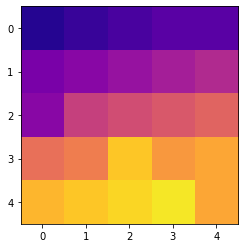

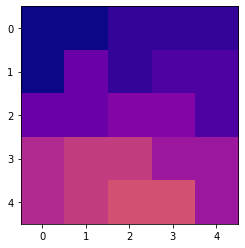

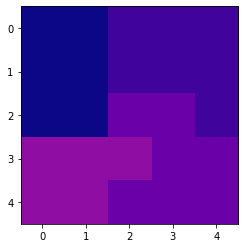

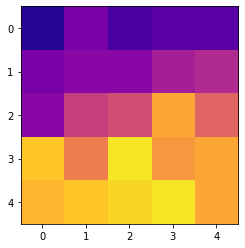

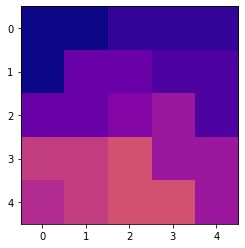

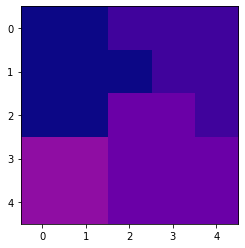

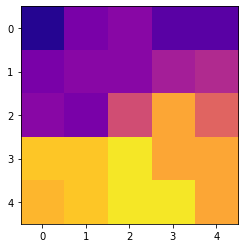

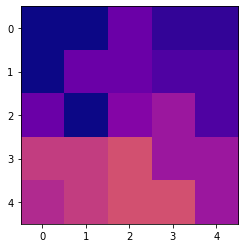

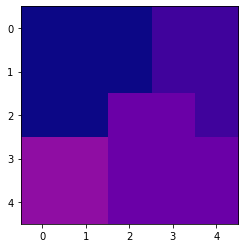

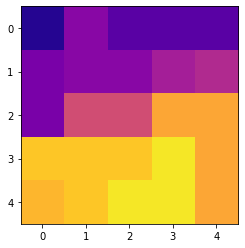

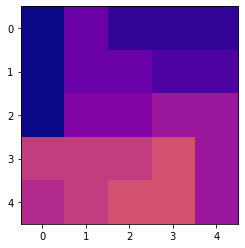

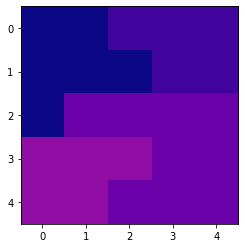

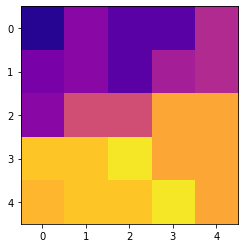

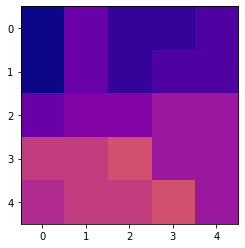

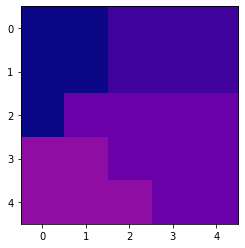

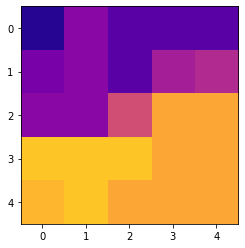

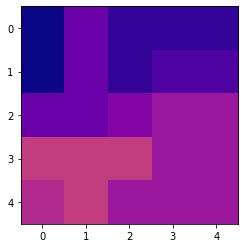

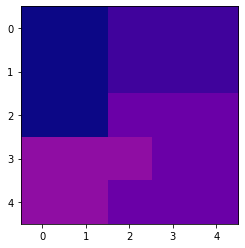

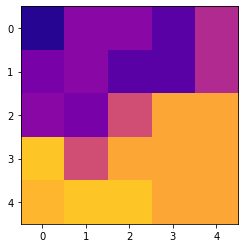

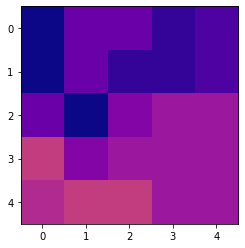

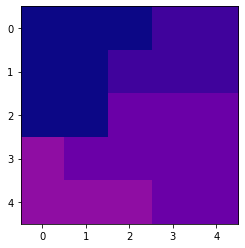

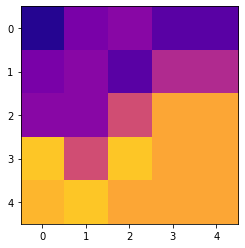

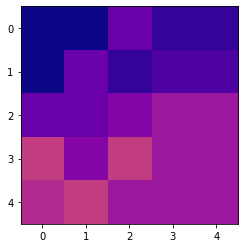

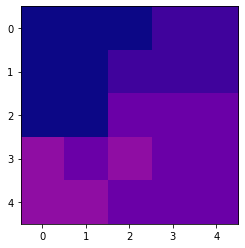

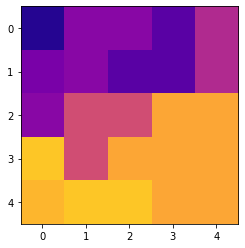

KeyboardInterrupt: ignored

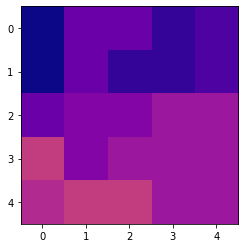

In [8]:
#main

# Simulate and plot results
initialize(pattern=9, printy=False)
for year in range(15):
    update(printy=False)
    observe(year, ca_level="vassal", color_map="plasma")
    display.display(gcf())
    observe(year, ca_level="lord", color_map="plasma")
    display.display(gcf())
    observe(year, ca_level="governor", color_map="plasma")
    display.display(gcf())
    time.sleep(1)
    display.clear_output(wait=True) #comment for whole output
    plt.close()
plt.show()
